# **This is the code for Naive Bayes classifier. Below is the original code I adapted from.**

# The codes can be used in the jupyter notebook as well (with minimal adaptation)

# Source:

https://levelup.gitconnected.com/movie-review-sentiment-analysis-with-naive-bayes-machine-learning-from-scratch-part-v-7bb869391bab


In [1]:
!pip install wordcloud

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import string
import re
import matplotlib.pyplot as plt
import math
from matplotlib import rc
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
nltk.download('stopwords')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# **Importing Training dataset & checking distribution**

# 1427 examples are labeled in the training dataset. 

# There are three types of training dataset (one for each category).

1) train_data_1400_pos (dataset for positive socioemotional category)

2) train_data_1400_neg (dataset for negative socioemotional category)

3) train_data_1400_task (dataset for task-focused category)

# After downloading the dataset (from /data folder), change path in order to load the file (for own use)

The below is only for COLAB environment

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Colab Datasets/train_data_1400_pos.csv",encoding= 'unicode_escape') # positive socioemotional
#train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Colab Datasets/train_data_1400_neg.csv",encoding= 'unicode_escape') # negative socioemotional
#train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Colab Datasets/train_data_1400_task.csv",encoding= 'unicode_escape') # task-focused

In [5]:
train.head()

,id,pos,comment_text
0,1,1,"Hello, how are you doing today?"
1,2,1,I am doing good. How about you?
2,3,1,very well thank you. I'm here today to see if ...
3,4,1,I am might be. Tell me a little about it.
4,5,0,Save the Children is an international non-gove...


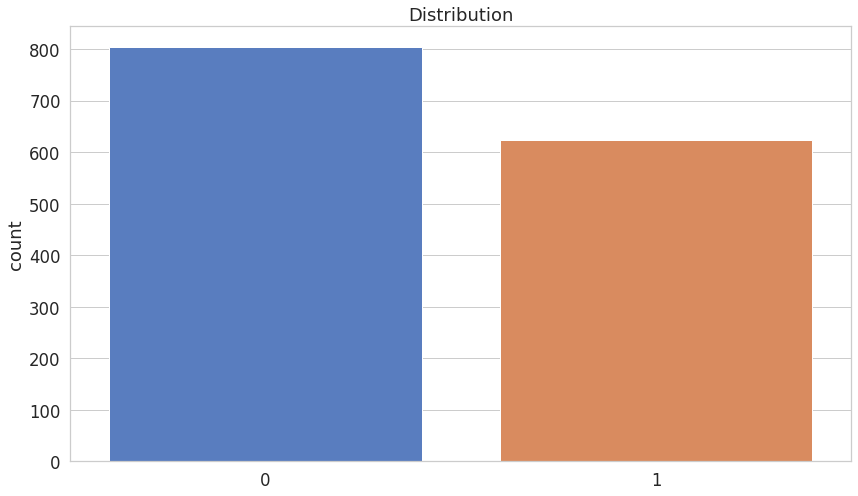

In [6]:
f = sns.countplot(x='pos', data=train)
f.set_title("Distribution")
f.set_xticklabels(['0', '1'])
plt.xlabel("");

# **Creating a word cloud of frequently used words in the dataset**

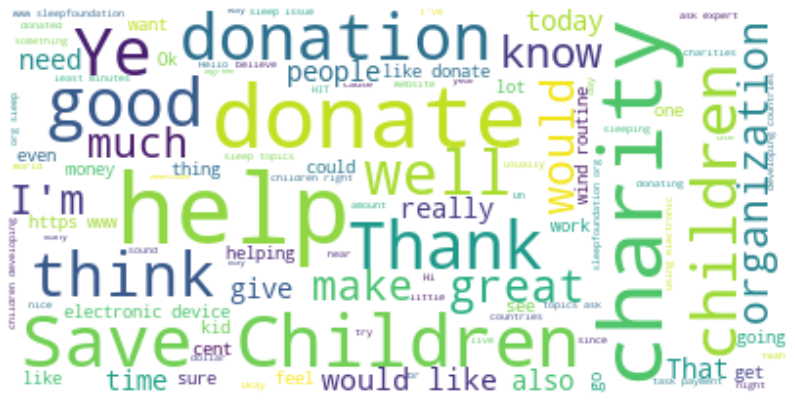

In [7]:
text = " ".join(comment_text for comment_text in train.comment_text)


wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=stopwords.words("english")).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();

# **Preprocessing: Cleaning and Tokenization**

# Here, I clean the text (remove HTML tags, remove anything that is not a letter or space, replace excessive spacing with a single one).

# In addition, text are split into indiviual words and stop words are removed. 

In [0]:
class Tokenizer:
  
  def clean(self, text):
      no_html = BeautifulSoup(text).get_text()
      clean = re.sub("[^a-z\s]+", " ", no_html, flags=re.IGNORECASE)
      return re.sub("(\s+)", " ", clean)

 
  def tokenize(self, text):
      clean = self.clean(text).lower()
      stopwords_en = stopwords.words("english")
      return [w for w in re.split("\W+", clean) if not w in stopwords_en]

# **Implementing Multinomial Naive Bayes**

# Laplace smoothing is used 

In [0]:
class MultinomialNaiveBayes:
  
    def __init__(self, classes, tokenizer):
      self.tokenizer = tokenizer
      self.classes = classes
      
    def group_by_class(self, X, y):
      data = dict()
      for c in self.classes:
        data[c] = X[np.where(y == c)]
      return data
           
    def fit(self, X, y):
        self.n_class_items = {}
        self.log_class_priors = {}
        self.word_counts = {}
        self.vocab = set()

        n = len(X)
        
        grouped_data = self.group_by_class(X, y)
        
        for c, data in grouped_data.items():
          self.n_class_items[c] = len(data)
          self.log_class_priors[c] = math.log(self.n_class_items[c] / n)
          self.word_counts[c] = defaultdict(lambda: 0)
          
          for text in data:
            counts = Counter(self.tokenizer.tokenize(text))
            for word, count in counts.items():
                if word not in self.vocab:
                    self.vocab.add(word)

                self.word_counts[c][word] += count
                
        return self
      
    def laplace_smoothing(self, word, text_class):
      num = self.word_counts[text_class][word] + 1
      denom = self.n_class_items[text_class] + len(self.vocab)
      return math.log(num / denom)
      
    def predict(self, X):
        result = []
        for text in X:
          
          class_scores = {c: self.log_class_priors[c] for c in self.classes}

          words = set(self.tokenizer.tokenize(text))
          for word in words:
              if word not in self.vocab: continue

              for c in self.classes:
                
                log_w_given_c = self.laplace_smoothing(word, c)
                class_scores[c] += log_w_given_c
                
          result.append(max(class_scores, key=class_scores.get))

        return result

# **Splitting training and testing dataset**

# 80% training and 20% testing

In [0]:
X = train['comment_text'].values
y = train['pos'].values
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# **Evaluating the model**

# Fit and predict functions (as defined in the above code) are used to fit the model into the training dataset and predict the classes in the testing dataet

In [0]:
MNB = MultinomialNaiveBayes(
    classes=np.unique(y), 
    tokenizer=Tokenizer()
).fit(X_train, y_train)

In [0]:
y_hat = MNB.predict(X_test)

In [13]:
accuracy_score(y_test, y_hat)

0.7307692307692307

# **Classification reports (accuracy, precision, recall, f1-score)**

In [14]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.67      0.96      0.79       147
           1       0.92      0.49      0.64       139

    accuracy                           0.73       286
   macro avg       0.79      0.72      0.71       286
weighted avg       0.79      0.73      0.71       286



In [15]:
cnf_matrix = confusion_matrix(y_test, y_hat)
cnf_matrix

array([[141,   6],
       [ 71,  68]])

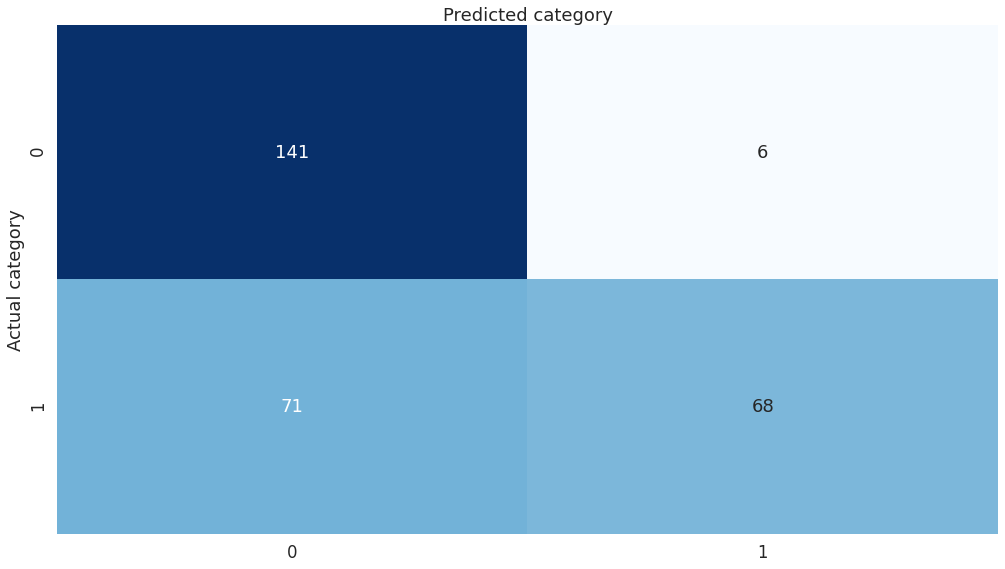

In [16]:
class_names = ["0", "1"]
fig,ax = plt.subplots()


sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('Actual category')
plt.xlabel('Predicted category');